In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('/Users/nicolasdemuynck/BeCode/GNT-ARAI-1.25/Content/00.Use cases/arinti/20200124_ews_observations.csv',
                   low_memory=False)

In [3]:
data.dropna(inplace=True)

In [35]:
patient = data.loc[(data['PatientId'] == 1743)]
patient = patient[-10:]
patient.head(5)

,PatientId,ObservationDate,EwsProcedure,EWS_Total,SBP,SBP_Score,LOC,LOC_Score,SpO2,SpO2_Score,Add_O2,Add_O2_Score,HR,HR_Score,RR,RR_Score,TEMP,TEMP_Score
170485,1743,2019-12-31 10:27:25.0000000,NEWS2,1,115.0,0.0,ALERT,0,97.0,0.0,False,0.0,97,1,18,0,37.3,0
170584,1743,2019-12-31 13:34:06.0000000,NEWS2,3,114.0,0.0,ALERT,0,93.0,0.0,False,0.0,104,1,21,2,37.3,0
170745,1743,2019-12-31 18:06:44.0000000,NEWS2,1,122.0,0.0,ALERT,0,95.0,0.0,False,0.0,105,1,20,0,37.6,0
170925,1743,2019-12-31 23:35:55.0000000,NEWS2,1,125.0,0.0,ALERT,0,95.0,0.0,False,0.0,98,1,18,0,36.9,0
170967,1743,2020-01-01 01:58:28.0000000,NEWS2,1,126.0,0.0,ALERT,0,95.0,0.0,False,0.0,96,1,16,0,37.1,0


In [36]:
df = patient[['ObservationDate', 'TEMP']]

In [37]:
df['ObservationDate'] =  pd.to_datetime(df['ObservationDate']) #make datetime object
df.dtypes

ObservationDate    datetime64[ns]
TEMP                      float64
dtype: object

In [38]:
df.head(5)

,ObservationDate,TEMP
170485,2019-12-31 10:27:25,37.3
170584,2019-12-31 13:34:06,37.3
170745,2019-12-31 18:06:44,37.6
170925,2019-12-31 23:35:55,36.9
170967,2020-01-01 01:58:28,37.1


In [39]:
df.shape

(10, 2)

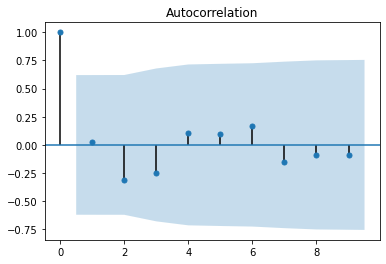

In [40]:
# ACF plot of time series
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df.TEMP)
plt.show() #95% confidence intervals are drown (default)

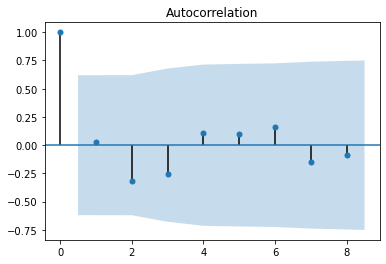

In [41]:
# zoomed-out ACF plot of time series : if tapers to 0 = AR model

plot_acf(df.TEMP, lags = 8)
plt.show()

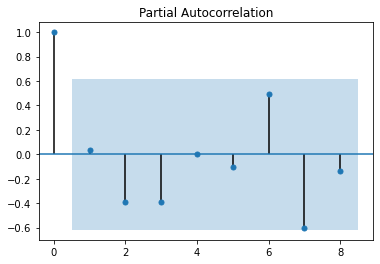

In [42]:
# PACF plot of time series: if tapers to O => MA model

from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df.TEMP, lags = 8)
plt.show()

In [43]:
# if both ACF en PACF don't taper to O , data is non-stationairy => ARIMA MODEL

In [44]:
# grid search ARIMA parameters for time series
import warnings
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    
    # calculate out-of-sample error
    rmse = sqrt(mean_squared_error(test, predictions))
    return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values): 
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    rmse = evaluate_arima_model(dataset, order)
                    if rmse < best_score:
                        best_score, best_cfg = rmse, order 
                        print('ARIMA%s RMSE=%.3f' % (order,rmse))
                except:
                        continue
    print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

In [45]:
X = patient.TEMP.values
print(X.shape)

(10,)


In [46]:
# evaluate parameters
#p_values = [0, 1, 2, 4, 6, 8, 10]
p_values = range(0,3)
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(X, p_values, d_values, q_values)

ARIMA(0, 0, 0) RMSE=0.474
ARIMA(0, 0, 2) RMSE=0.409
ARIMA(0, 1, 1) RMSE=0.400
Best ARIMA(0, 1, 1) RMSE=0.400


In [48]:
# how to interpret:
# it is modelled by zero lagged value and 1 error term (p_value, q_value)
# 1x time the series has been differenced to achieve stationarity (d_value)

# *Stationarity is a must before you can model your data: what stationarity refers to is 
# *constant mean and variance. 

In [110]:
# alternative way of finding the right p, d, q values with auto.arima
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest

adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(patient.TEMP) #first check out if data is stationairy. In this case True.
# We don't need to use the Integrated (I) concept

(0.34363915331217754, True)

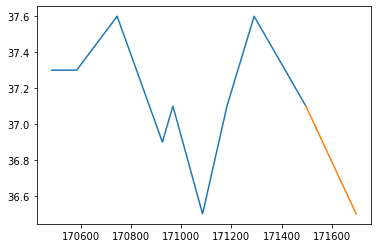

In [111]:
train = patient.TEMP[:9] #train and test split
test = patient.TEMP[-2:]
plt.plot(train)
plt.plot(test)
plt.show()

In [112]:
arima_model = auto_arima(train, start_p=0, d=1, start_q=0,
                        max_p=5, max_d=5, max_q=0, start_P=0,
                        D=0, start_Q=0, max_P=5, max_D=5,
                        max_Q=5, m=12, seasonal=True,
                        error_action='warn', trace=True,
                        supress_warnings=True, stepwise=True,
                        random_state=20,n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=14.924, Time=0.04 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=17.313, Time=0.08 sec
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=16.924, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=12.946, Time=0.01 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=16.924, Time=0.02 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=18.924, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=15.313, Time=0.09 sec

Best model:  ARIMA(0,1,0)(0,0,0)[12]          
Total fit time: 0.400 seconds


In [113]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                    9
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  -5.473
Date:                Sat, 09 Jan 2021   AIC                             12.946
Time:                        20:34:50   BIC                             13.025
Sample:                             0   HQIC                            12.410
                                  - 9                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2300      0.230      0.998      0.318      -0.222       0.682
===================================================================================
Ljung-Box (Q):                        4.96   Jarque-Bera (JB):                 0.85
Prob(Q):                              0.66   Prob(JB):                         0.65
Heteroskedasticity (H):               1.48   Skew:                            -0.19
Prob(H) (two-sided):                  0.75   Kurtosis:                         1.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [114]:
#Forecasting on the test data
from pandas import DataFrame
prediction = pd.DataFrame(arima_model.predict(n_periods = 2), index=test.index) #n_periods = amount of test data
prediction.columns = ['predicted_TEMP']
prediction

,predicted_TEMP
171496,37.1
171696,37.1


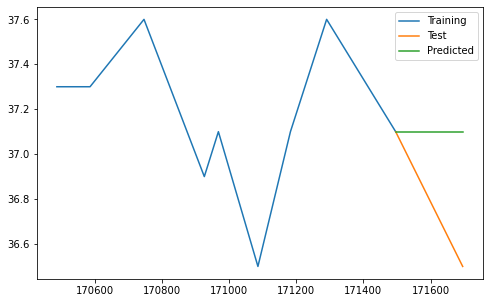

In [115]:
# TEMP forecasted on the test data
plt.figure(figsize=(8,5))
plt.plot(train, label="Training")
plt.plot(test, label="Test")
plt.plot(prediction, label="Predicted")
plt.legend(loc="Left Corner")
plt.show()
# plotting train vs test vs prediction

In [116]:
prediction['TEMP'] = test
prediction.head(5)

,predicted_TEMP,TEMP
171496,37.1,37.1
171696,37.1,36.5


In [118]:
from sklearn.metrics import r2_score
r2_score(prediction['TEMP'], prediction['predicted_TEMP'])

-1.0

In [91]:
# Go further on grid search parameters and make predictions

Test RMSE: 0.595


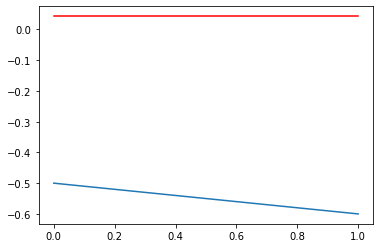

In [140]:
# fit and evaluate an AR model
from pandas import read_csv
from matplotlib import pyplot
from statsmodels.tsa.ar_model import AR
from sklearn.metrics import mean_squared_error
import numpy
from math import sqrt
# create a difference transform of the dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return numpy.array(diff)

# Make a prediction give regression coefficients and lag obs
def predict(coef, history):
    yhat = coef[0]
    for i in range(1, len(coef)):
        yhat += coef[i] * history[-i]
    return yhat

# split dataset
X = difference(patient.TEMP.values)
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:]

# train autoregression
model = AR(train)
model_fit = model.fit(maxlag=0, disp=False) #fill in lag from grid search
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = [train[i] for i in range(len(train))]
predictions = list()
for t in range(len(test)):
    yhat = predict(coef, history)
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
rmse = sqrt(mean_squared_error(test, predictions)) 
print('Test RMSE: %.3f' % rmse)

# plot
plt.plot(test)
plt.plot(predictions, color='red') 
plt.show()

In [149]:
# fit an AR model and save the whole model to file
from pandas import read_csv
from statsmodels.tsa.ar_model import AR
import numpy
# create a difference transform of the dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
        return numpy.array(diff)

# fit model
model = AR(X)
model_fit = model.fit(maxlag=1, disp=False)

# save model to file 
model_fit.save('ar_model.pkl')

# save the differenced dataset 
numpy.save('ar_data.npy', X)

# save the last ob
numpy.save('ar_obs.npy', [patient.TEMP.values[-1]])

In [150]:
# fit an AR model and manually save coefficients to file
from pandas import read_csv
from statsmodels.tsa.ar_model import AR
import numpy

# create a difference transform of the dataset
def difference(dataset):
    diff = list()
    for i in range(1, len(dataset)):
        value = dataset[i] - dataset[i - 1]
        diff.append(value)
    return numpy.array(diff)

X = difference(patient.TEMP.values)

# fit model
window_size = 0
model = AR(X)
model_fit = model.fit(maxlag=window_size, disp=False) # save coefficients
coef = model_fit.params
numpy.save('man_model.npy', coef)

# save lag
lag = X[-window_size:]
numpy.save('man_data.npy', lag)

# save the last ob
numpy.save('man_obs.npy', [patient.TEMP.values[-1]])

In [151]:
# load the manually saved model from file
import numpy
coef = numpy.load('man_model.npy') 
print(coef)
lag = numpy.load('man_data.npy') 
print(lag)
last_ob = numpy.load('man_obs.npy') 
print(last_ob)                   

[-0.08888889]
[ 0.   0.3 -0.7  0.2 -0.6  0.6  0.5 -0.5 -0.6]
[36.5]


In [152]:
# load AR model from file and make a one-step prediction
from statsmodels.tsa.ar_model import ARResults 
import numpy
# load model
model = ARResults.load('ar_model.pkl')
data = numpy.load('ar_data.npy')
last_ob = numpy.load('ar_obs.npy')
# make prediction
predictions = model.predict(start=len(data), end=len(data)) # transform prediction
yhat = predictions[0] + last_ob[0]
print('Prediction: %f' % yhat)

Prediction: 36.556676
